### Python金融风控策略实战（基于Jupyter Notebook）
## <center>德国信贷风控数据建模（步骤5：logistic逻辑回归模型）</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.11.14</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>

### 第一步：导入需要使用的python库，并进行数据描述

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") # 忽略警告
from sklearn.model_selection import train_test_split
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.metrics import confusion_matrix,recall_score, auc, roc_curve,precision_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
matplotlib.use(arg='Qt5Agg')
matplotlib.rcParams['font.size']=15       
%matplotlib inline

### 数据概况
数据来源：加州大学（UCI）欧文机器学习库    
http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29  

数据概况：“德国信用数据”将申请贷款的人分为“好信用”和“坏信用”，样本数据1000人，数据维度20维   

特征向量：1.支票账户状态；2.借款周期；3.历史信用；4.借款目的；5.信用额度；6.储蓄账户状态；7.当前就业状态；8.分期付款占可支配收入百分比；9.性别与婚姻状态；10.他人担保信息；11.现居住地；12.财产状态；13.年龄；14.其他分期情况；15.房产状态；16.信用卡数量；17.工作状态；18.赡养人数；19.电话号码注册情况；20.是否有海外工作经历

特征向量对应英文：1.status_account, 2.duration, 3.credit_history, 4,purpose, 5.amount, 6.svaing_account, 7.present_emp, 8.income_rate, 9.personal_status, 10.other_debtors, 11.residence_info, 12.property, 13.age, 14.inst_plans, 15.housing, 16.num_credits, 17.job, 18.dependents, 19.telephone, 20.foreign_worker    

输出结果：好信用（0），坏信用（1）   

数据收录时间：1994-11-17    

数据上传者：Professor Dr. Hans Hofmann 汉斯霍夫曼博士（德国汉堡大学）  

### 第二步：下载数据至本地，保存成csv格式，使用pandas导入数据
将数据分为data_train（训练集）和 data_test（测试集）两部分，其中训练集占总数据量80%，即800条样本数据，测试集占20%，即200条样本数据，两个数据集均通过随机抽取得到。 

In [2]:
def data_read(data_path,file_name):
    df = pd.read_csv( os.path.join(data_path, file_name), delim_whitespace = True, header = None )
    columns = ['status_account','duration','credit_history','purpose', 'amount',
               'svaing_account', 'present_emp', 'income_rate', 'personal_status',
               'other_debtors', 'residence_info', 'property', 'age',
               'inst_plans', 'housing', 'num_credits',
               'job', 'dependents', 'telephone', 'foreign_worker', 'target']
    df.columns = columns
    # 将标签变量由状态1,2转为0,1; 其中0表示好信用，1表示坏信用
    df.target = df.target - 1
    # 将数据分为data_train（训练集）和 data_test（测试集）两部分
    # 按目标变量进行分层抽样，即训练集和测试集中，好坏样本的比例相同。
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=0,stratify=df.target) 
    # 由于训练集、测试集是随机划分，索引是乱的，需要重新排序
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    return data_train, data_test

if __name__ == '__main__':
    data_path = os.path.join('C:\\Users\\lotbear\\Desktop\\Data-science！','金融风控实战数据')
    file_name = 'german.csv'
    # 读取数据
    data_train, data_test = data_read(data_path,file_name)

查看训练集数据信息

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   status_account   800 non-null    object
 1   duration         800 non-null    int64 
 2   credit_history   800 non-null    object
 3   purpose          800 non-null    object
 4   amount           800 non-null    int64 
 5   svaing_account   800 non-null    object
 6   present_emp      800 non-null    object
 7   income_rate      800 non-null    int64 
 8   personal_status  800 non-null    object
 9   other_debtors    800 non-null    object
 10  residence_info   800 non-null    int64 
 11  property         800 non-null    object
 12  age              800 non-null    int64 
 13  inst_plans       800 non-null    object
 14  housing          800 non-null    object
 15  num_credits      800 non-null    int64 
 16  job              800 non-null    object
 17  dependents       800 non-null    in

In [4]:
print('训练集中"好信用target=0"样本量：',sum(data_train.target ==0))
print('训练集中"坏信用target=1"样本量：',sum(data_train.target ==1))

训练集中"好信用target=0"样本量： 560
训练集中"坏信用target=1"样本量： 240


### 第三步：区分离散/连续变量
定义函数（1）：" 离散变量 / 连续变量 " 区分函数

In [5]:
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    # 先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float',
                                                                  'int32','float32',
                                                                  'int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

实现：" 离散变量 vs 连续变量 " 分离   

a. 对于取值小于10种数值的连续型变量，改为离散变量，且将数值转化为字符串；    

b. 在对上述连续变量进行离散变量转化的过程中，先要将变量中的空值进行bool数标注，只将取值中非空的数值转换为字符串，保留空值属性；     

c. 注意：有些变量从表象上看是数值型连续变量，但从业务角度任务是离散型变量，如借款期限12/18/24/36期，这时需要主动将这些数值型变量改为字符串型离散变量。

In [6]:
feature_names = list(data_train.columns)
feature_names.remove('target')
categorical_var,numerical_var = category_continue_separation(data_train,feature_names)
print('初始7个连续变量：','\n',numerical_var)
print('='*80)
print('初始连续变量情况：')
# 对于取值小于10种数值的连续型变量，改为离散变量，且将数值转化为字符串
for s in set(numerical_var):
    print('变量'+s+'可能取值'+str(len(data_train[s].unique())))
    if len(data_train[s].unique())<=10:
        categorical_var.append(s)
        numerical_var.remove(s)
        # 同时将后加的数值变量转为字符串
        # 先用bool数值将变量取值中空值标注成 FALSE（0）
        index_1 = data_train[s].isnull()
        # 如果变量中有空值，则对非空值进行字符串转化
        if sum(index_1) > 0:
            data_train.loc[~index_1,s] = data_train.loc[~index_1,s].astype('str')
        # 如果变量中没有空值，则直接进行字符串转化
        else:
            data_train[s] = data_train[s].astype('str')
        index_2 = data_test[s].isnull()
        if sum(index_2) > 0:
            data_test.loc[~index_2,s] = data_test.loc[~index_2,s].astype('str')
        else:
            data_test[s] = data_test[s].astype('str')

print('='*80)
print('经转换后，剩余连续变量：','\n',numerical_var)
print('='*80)
print('离散变量：','\n',categorical_var)

初始7个连续变量： 
 ['duration', 'amount', 'income_rate', 'residence_info', 'age', 'num_credits', 'dependents']
初始连续变量情况：
变量age可能取值53
变量income_rate可能取值4
变量residence_info可能取值4
变量amount可能取值744
变量dependents可能取值2
变量num_credits可能取值4
变量duration可能取值30
经转换后，剩余连续变量： 
 ['duration', 'amount', 'age']
离散变量： 
 ['status_account', 'credit_history', 'purpose', 'svaing_account', 'present_emp', 'personal_status', 'other_debtors', 'property', 'inst_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'income_rate', 'residence_info', 'dependents', 'num_credits']


训练集数据中，连续变量的类别分布

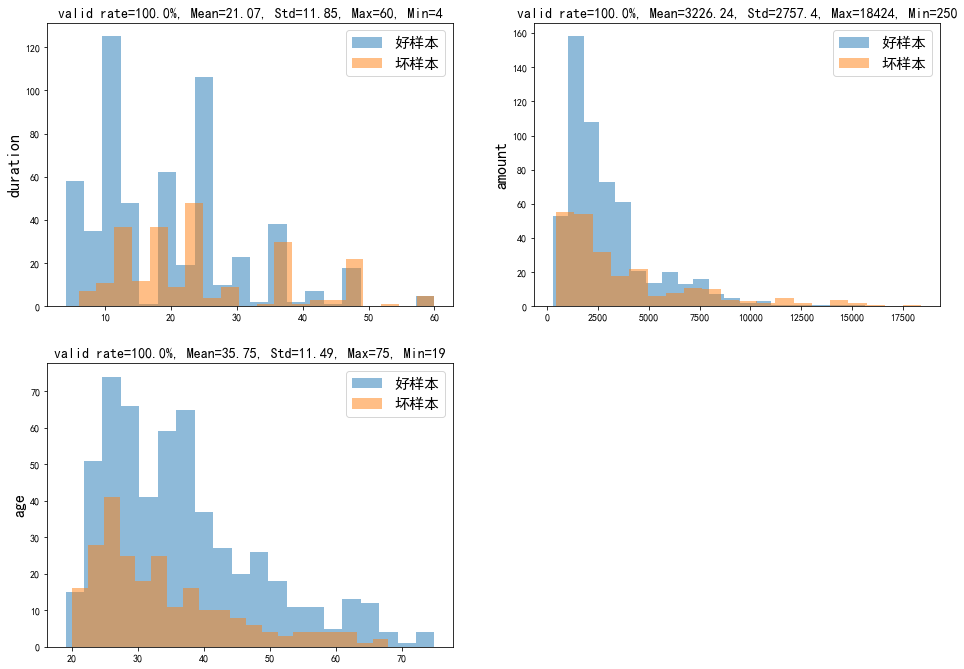

In [7]:
## 连续变量不同类别下的分布
j=1
plt.figure(figsize=(16,24)) 
for i in numerical_var:
    ##取非缺失值的数据（先用布尔值进行索引判断，再对具体列取值）
    df_temp = data_train.loc[~data_train[i].isnull(),[i,'target']]
    df_good = df_temp[df_temp.target == 0]
    df_bad = df_temp[df_temp.target == 1]
    ## 计算统计量
    valid = round(df_temp.shape[0]/data_train.shape[0]*100,2) # 非空数据占比，即有效数据占比
    Mean = round(df_temp[i].mean(),2) 
    Std = round(df_temp[i].std(),2)
    Max = round(df_temp[i].max(),2)
    Min = round(df_temp[i].min(),2)
    ## 统计性描述绘图
    plt.subplot(4,2,j)
    plt.hist(df_good[i],bins =20, alpha=0.5,label='好样本')
    plt.hist(df_bad[i],bins =20, alpha=0.5,label='坏样本')
    plt.ylabel(i,fontsize=16)
    plt.title( 'valid rate='+str(valid)+'%, Mean='+str(Mean) + ', Std='+str(Std)+', Max='+str(Max)+', Min='+str(Min),fontsize=14)
    plt.legend(fontsize=15)
    j=j+1

离散变量不同类别下的分布   

注：坏样本取值=1，好样本取值=0，sum（target）的大小代表坏样本的数量    

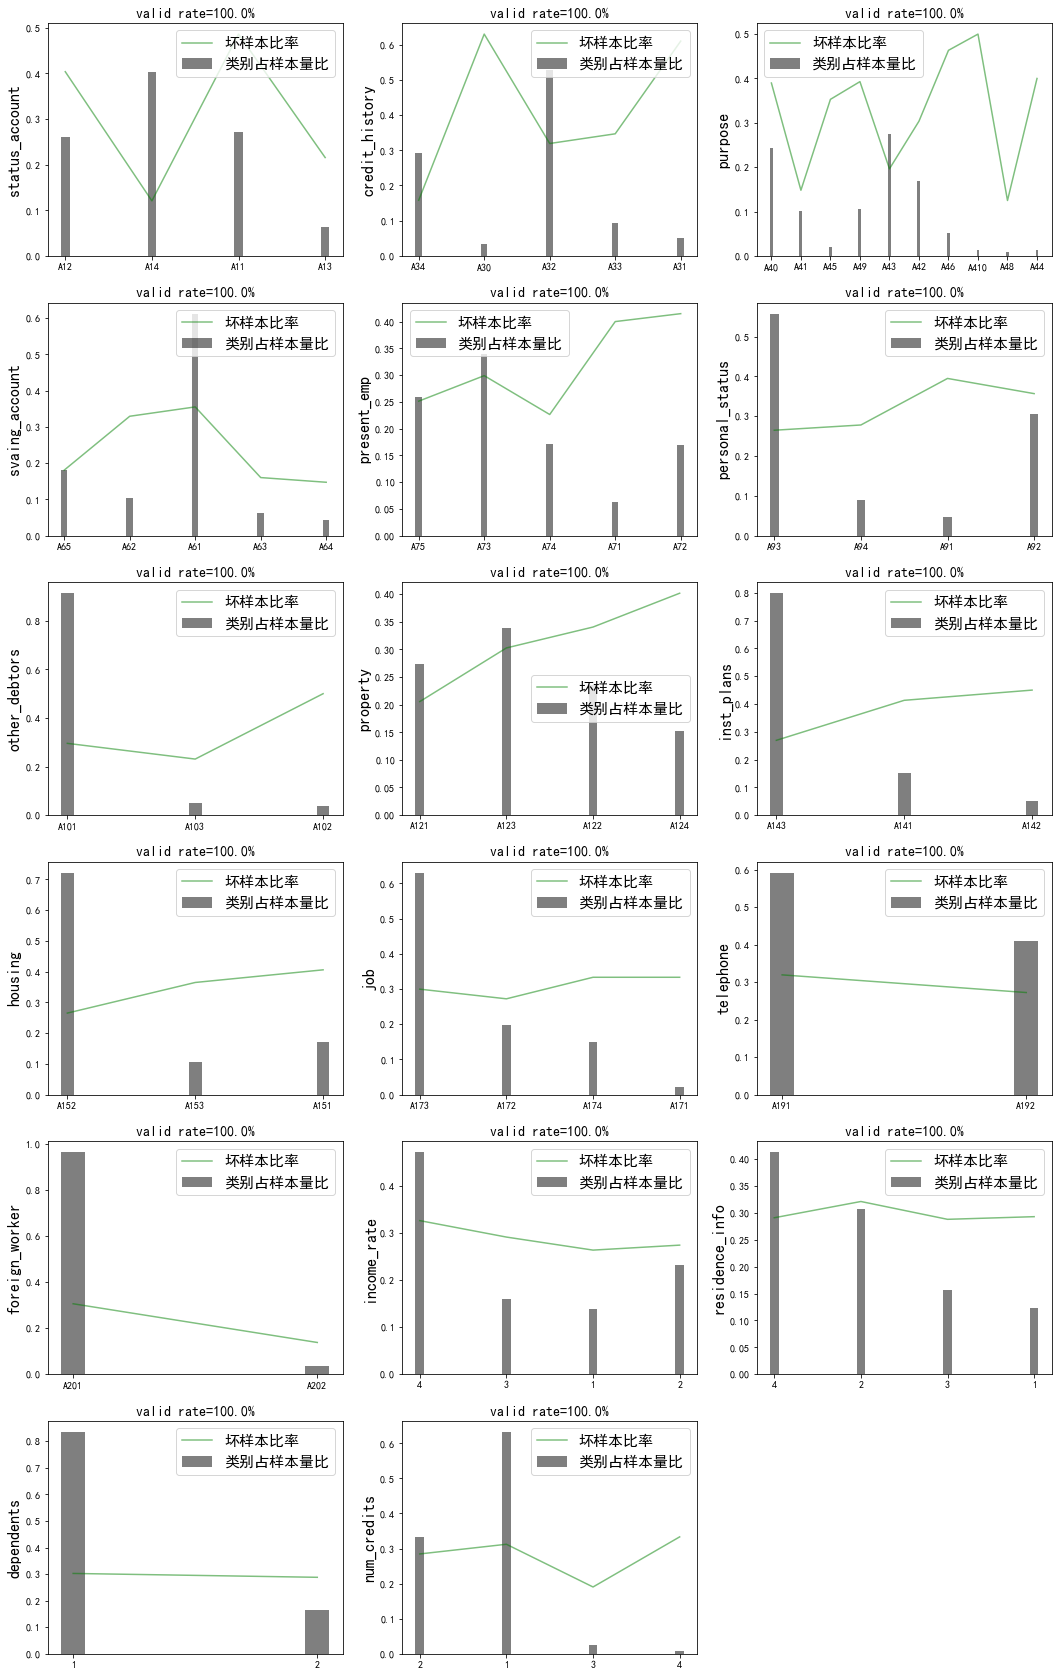

In [8]:
##离散变量不同类别下的分布
k=1
plt.figure(figsize=(18,30)) 
for i in categorical_var:
    ##非缺失值数据
    df_temp = data_train.loc[~data_train[i].isnull(),[i,'target']]
    df_bad = df_temp[df_temp.target == 1]
    valid = round(df_temp.shape[0]/data_train.shape[0]*100,2)
    bad_rate = []
    bin_rate = []
    var_name = []
    for j in data_train[i].unique():         
        if pd.isnull(j):
            df_1 = data_train[data_train[i].isnull()]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/data_train.shape[0])
            var_name.append('NA')
        else:
            df_1 = data_train[data_train[i] == j]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/data_train.shape[0])
            var_name.append(j)
    df_2 = pd.DataFrame({'var_name':var_name,'bin_rate':bin_rate,'bad_rate':bad_rate})
    ## 绘图
    plt.subplot(6,3,k)
    plt.bar(np.arange(1,df_2.shape[0]+1),df_2.bin_rate,0.1,color='black',alpha=0.5, label='类别占样本量比')
    plt.xticks(np.arange(1,df_2.shape[0]+1), df_2.var_name)
    plt.plot( np.arange(1,df_2.shape[0]+1),df_2.bad_rate,  color='green', alpha=0.5,label='坏样本比率')   
    plt.ylabel(i,fontsize=16)
    plt.title( 'valid rate='+str(valid)+'%',fontsize=14)
    plt.legend(fontsize=15)
    k=k+1

### 第四步：对连续变量 / 离散变量进行类别分箱

In [9]:
# 连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3, mmax=12,
                                     bin_rate=0.01, stop_limit=0.05, bin_min_num=20)

# 离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3,
                                     mmax=8, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)

if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]
        
print('删除分箱数只有单个的变量：','共',len(del_key),'个')
print(del_key)

### 训练集数据分箱

# 连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , 
                                   varbin_meth.cont_var_bin_map(data_train[i], 
                                   dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , 
                                   varbin_meth.disc_var_bin_map(data_train[i], 
                                   dict_disc_bin[i]) ], axis = 1)

### 测试集数据分箱
# 连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , 
                                varbin_meth.cont_var_bin_map(data_test[i], 
                                dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , 
                                  varbin_meth.disc_var_bin_map(data_test[i], 
                                  dict_disc_bin[i]) ], axis = 1)

### 组成分箱后的训练集与测试集
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

print('='*80)
print('训练集18个变量分箱结果：')
data_train_bin

删除分箱数只有单个的变量： 共 2 个
['other_debtors', 'foreign_worker']
训练集18个变量分箱结果：


,duration_BIN,amount_BIN,age_BIN,status_account_BIN,credit_history_BIN,purpose_BIN,svaing_account_BIN,present_emp_BIN,personal_status_BIN,property_BIN,inst_plans_BIN,housing_BIN,job_BIN,telephone_BIN,income_rate_BIN,residence_info_BIN,dependents_BIN,num_credits_BIN,target
0,5,2,7,2,1,4,1,2,1,1,1,1,2,2,4,2,2,1,0
1,5,5,5,2,4,2,2,2,2,2,2,1,2,1,3,2,2,1,0
2,5,2,6,1,1,4,3,3,2,1,1,1,2,1,4,4,2,1,0
3,6,2,3,1,4,4,3,3,1,2,1,1,2,2,4,4,2,1,0
4,2,1,10,3,1,4,3,2,1,1,1,1,1,2,4,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3,2,3,2,1,4,1,3,1,2,2,1,2,2,2,2,2,2,0
796,2,2,3,3,2,4,3,4,1,4,1,2,3,1,3,4,2,2,1
797,3,2,8,1,1,2,1,2,2,1,1,1,2,1,4,4,2,1,0
798,5,3,1,2,1,3,1,2,1,4,1,3,2,2,4,2,2,1,0


### 第五步：对分箱后的数据，进行WOE编码

In [10]:
# WOE编码
var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

# 训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,data_path,
                                var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')

# 测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,data_path,var_all_bin, 
                                                  data_test_bin.target, 'dict_woe_map',flag='test')

print('训练集WOE编码:')
df_train_woe[var_woe_name]

训练集WOE编码:


,duration_BIN_woe,amount_BIN_woe,age_BIN_woe,status_account_BIN_woe,credit_history_BIN_woe,purpose_BIN_woe,svaing_account_BIN_woe,present_emp_BIN_woe,personal_status_BIN_woe,property_BIN_woe,inst_plans_BIN_woe,housing_BIN_woe,job_BIN_woe,telephone_BIN_woe,income_rate_BIN_woe,residence_info_BIN_woe,dependents_BIN_woe,num_credits_BIN_woe
0,-0.010152,-0.254159,-0.762140,0.301308,-0.824988,0.393733,-0.730888,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.001890,0.090026,0.122148,-0.043675,0.01138,-0.108214
1,-0.010152,-0.538997,-0.123481,0.301308,1.326871,-0.656780,0.135802,-0.244884,0.204582,0.012270,0.534206,-0.171998,-0.001890,-0.136336,-0.041594,-0.043675,0.01138,-0.108214
2,-0.010152,-0.254159,0.211309,-1.138115,-0.824988,0.393733,0.250611,-0.005277,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,0.122148,0.098752,0.01138,-0.108214
3,0.746493,-0.254159,-0.060259,-1.138115,1.326871,0.393733,0.250611,-0.005277,-0.175031,0.012270,-0.151537,-0.171998,-0.001890,0.090026,0.122148,0.098752,0.01138,-0.108214
4,-0.762140,0.431137,-0.370098,0.792238,-0.824988,0.393733,0.250611,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.136434,0.090026,0.122148,-0.043675,0.01138,-0.108214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.311939,-0.254159,-0.060259,0.301308,-0.824988,0.393733,-0.730888,-0.005277,-0.175031,0.012270,0.534206,-0.171998,-0.001890,0.090026,-0.126151,-0.043675,0.01138,0.058841
796,-0.762140,-0.254159,-0.060259,0.792238,0.089612,0.393733,0.250611,0.486683,-0.175031,0.448659,-0.151537,0.292301,0.154151,-0.136336,-0.041594,0.098752,0.01138,0.058841
797,-0.311939,-0.254159,-0.405465,-1.138115,-0.824988,-0.656780,-0.730888,-0.244884,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,0.122148,0.098752,0.01138,-0.108214
798,-0.010152,-0.604954,0.441833,0.301308,-0.824988,0.017575,-0.730888,-0.244884,-0.175031,0.448659,-0.151537,0.465930,-0.001890,0.090026,0.122148,-0.043675,0.01138,-0.108214


查看不同变量的IV值（information value）

In [11]:
print('查看训练集数据，不同变量的IV值：（共18个）')
dict_iv_values

查看训练集数据，不同变量的IV值：（共18个）


{'duration_BIN': 0.2918595066690165,
 'amount_BIN': 0.20572272141009934,
 'age_BIN': 0.15957676538559773,
 'status_account_BIN': 0.6147282330257565,
 'credit_history_BIN': 0.34240107311849893,
 'purpose_BIN': 0.24319295137678967,
 'svaing_account_BIN': 0.1701220951925,
 'present_emp_BIN': 0.09709327722537278,
 'personal_status_BIN': 0.03570166654981978,
 'property_BIN': 0.10381105880538871,
 'inst_plans_BIN': 0.08041152952203817,
 'housing_BIN': 0.07063923377032309,
 'job_BIN': 0.0077963182690151895,
 'telephone_BIN': 0.012261307240533585,
 'income_rate_BIN': 0.0153569405138668,
 'residence_info_BIN': 0.004494020924339555,
 'dependents_BIN': 0.000664673198277874,
 'num_credits_BIN': 0.006363965130025382}

取出训练数据与测试数据

In [12]:
x_train = df_train_woe[var_woe_name]
x_train = np.array(x_train)
y_train = np.array(data_train_bin.target)
    
x_test = df_test_woe[var_woe_name]
x_test = np.array(x_test)
y_test = np.array(data_test_bin.target)

### 第六步：logistic回归模型
a. 设置优化的2组超参数，其中C为正则项惩罚系数，共设7个值；class_weight为样本权重设置，共设3组值；   

b. 选择L2 正则项来抑制过拟合，选择 saga 作为优化算法   

c. cv=3 进行三折交叉验证，由于有7组超参数 C，3组超参数 class_weight，因此共需3\*7\*3=63次拟合   

d. 对训练集数据进行logistic逻辑回归拟合，网格搜索最优参数，并打印

In [13]:
# 设置优化参数
# C 为正则项惩罚系数（7组）
# class_weight 用字典形式为样本加权，来抑制样本不均衡（3组）
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}]}

# 初始化网格搜索
# 选择 L2 正则项来抑制过拟合，选择 saga 作为优化算法
# cv=3 进行三折交叉验证，由于有7组超参数 C，3组超参数 class_weight，因此共需3*7*3=63次拟合
lr_gsearch = GridSearchCV(
  estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
  param_grid=lr_param, cv=3, scoring='f1', n_jobs=-1, verbose=2)

#执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('logistic model best_score_ is {0},and best_params_ is {1}'.format(lr_gsearch.best_score_,
                                                                            lr_gsearch.best_params_))

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


logistic model best_score_ is 0.6502502330113034,and best_params_ is {'C': 1, 'class_weight': {1: 3, 0: 1}}


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.3s finished


In [14]:
# 用最优参数，初始化Logistic模型
LR_model_2 = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                class_weight=lr_gsearch.best_params_['class_weight'])

# 训练Logistic模型
LR_model_fit = LR_model_2.fit(x_train, y_train)

In [15]:
# 模型预测
y_pred = LR_model_fit.predict(x_test)
print('用训练好的LR模型，对测试集target数据进行预测：')
print('='*80)
print(y_pred)

用训练好的LR模型，对测试集target数据进行预测：
[1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0
 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0
 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0]


### 第七步：评估模型的预测能力
相关指标：   

a. <font color=red>混淆矩阵（confusion matrix）</font>：（机器学习默认以少数样本为正样本，即“坏信用target=1”的样本数据为正样本）    

真实 / 预测|正例|反例
---|:--:|---:
正例|TP（真正例）|FN（假反例）
反例|FP（假正例）|TN（真反例）

b. <font color=red>错误率（error rate）</font>：E =（FN+FP）/ (FN+FP+TP+TN)   

c. <font color=red>准确率（accuracy rate）</font>：Acc =（TP+TN）/ (FN+FP+TP+TN)   

c. <font color=red>召回率（recall rate）</font>:Recall = TP / TP+FN   

d. <font color=red>精准率（Precision rate）</font>：Precision = TP / TP+FP   

其中准确率和精确率容易混淆，准确率以预测结果为标准，衡量模型预测正反例的能力；精准率以预测结果中正例为标准，衡量预测结果中，正例被精准筛选出来的能力。   

In [16]:
# 计算混淆矩阵cnf_matrix、召回率recall、精准率precision、模型预测的准确率accuracy_score

cnf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])

recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('LR模型的召回率：',recall_value)
print('LR模型的精准率：',precision_value)
print('LR模型预测的正确率:',acc)
print('='*80)
print('测试集的混淆矩阵：')
cnf_matrix

LR模型的召回率： 0.7333333333333333
LR模型的精准率： 0.4943820224719101
LR模型预测的正确率: 0.695
测试集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,95,45
真实样本为反例,16,44


#### <font color=blue>对比查看训练集、测试集的P-R曲线（Precision-Recall）</font>
a. 以横轴为召回率 Recall rate，纵轴为精准率 Precision rate；   

b. 实际应用中，召回率和精准率是一对相互制约、此消彼长的指标，往往需要牺牲一种指标来提高另一种指标;  

c. 当我们要求模型的精准率越高时，对正例的准入条件就越高，准入的正例就越少，那么，能被正确筛选出来的正例就少，召回率就低。    
   
<font color=red>换言之，当业务需求是更准确地判断出<font color=blue>“坏信用”</font>时，这时模型倾向于更谨慎地标记<font color=blue>“坏信用”</font>，使其筛选出的样本减少，召回率降低；   
   
当业务需求是更多地筛选出<font color=blue>“坏信用”</font>时，这时精准率就需要适当下降。</font>

In [17]:
y_score_train = LR_model_fit.predict_proba(x_train)[:, 1]
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
train_precision, train_recall, _ = precision_recall_curve(y_train, y_score_train)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_score_test)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

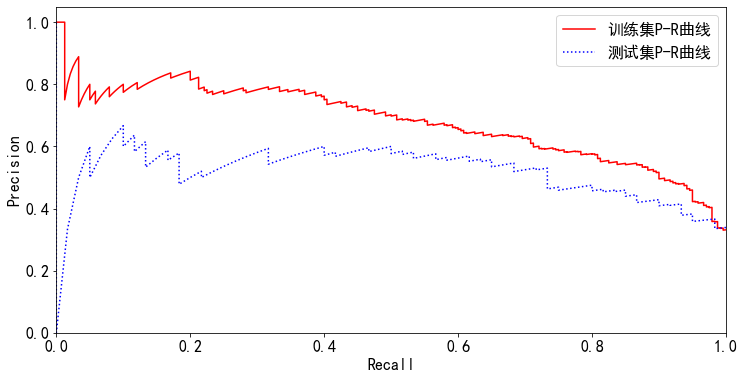

In [18]:
plt.figure(figsize=(12,6))  
plt.plot(train_recall, train_precision,color = 'r', linestyle='-',label='训练集P-R曲线')
plt.plot(test_recall, test_precision,color = 'b', linestyle=':',label='测试集P-R曲线')
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)

#### <font color=blue>查看测试集 正负样本的概率直方图</font>

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 8 Text major ticklabel objects>)

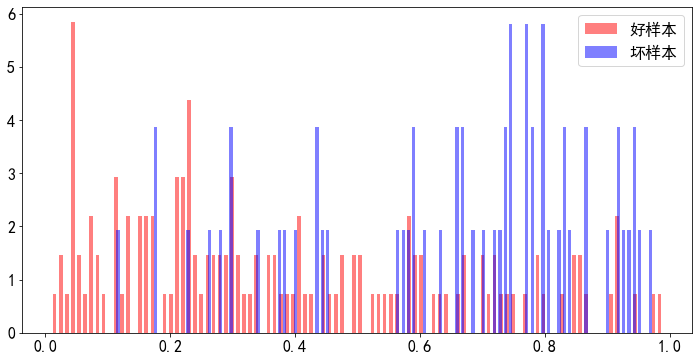

In [19]:
df_pre_all = pd.DataFrame({'y_score':y_score_test,'y_test':y_test})
# 按好坏样本进行分类
df_pre_good = df_pre_all.loc[df_pre_all.y_test==0,]
df_pre_bad = df_pre_all.loc[df_pre_all.y_test==1,]
# 按概率大小进行排序
df_pre_good = df_pre_good.sort_values(['y_score'])
df_pre_bad = df_pre_bad.sort_values(['y_score'])

plt.figure(figsize=(12,6))    
plt.hist(df_pre_good.y_score, bins =100, color = 'r',alpha=0.5,rwidth= 0.6, density=True,label='好样本') # density 概率密度分布
plt.hist(df_pre_bad.y_score, bins =100, color = 'b',alpha=0.5,rwidth= 0.6, density=True,label='坏样本')
plt.legend(fontsize=16)
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)

#### <font color=blue>查看测试集 ROC曲线</font>
a. FPR 假正率：FPR = FP / (FP+TN) 预测为正例，但实际为反例的样本，占所有反例样本的比例；   

b. TPR 真正率：TPR = TP / (TP+FN) 预测为正例，且实际为正例的样本，占所有正例样本的比例；   

c. ROC 曲线：Receiver Operating Characteristic,以 FPR 假正率为横轴，以 TPR 真正率为纵轴，将预测的target=1（坏信用）概率降序排列，每个概率作为 cutoff 切分点，计算所有样本的 TPR 和 FPR，并绘制成曲线；  

d. AUC (Area under the curve)为ROC曲线下方与坐标轴围成的面积，是ROC的量化数值，AUR越大则模型拟合效果越好，一般要求AUC大于0.75；   

e. 本例中，蓝色虚线表示，在舍弃50%好用户的前提下，可以避免50%的坏用户；若曲线从原点（0,0）沿纵坐标轴向上至（0,1），再沿横坐标至（1,1）则表示：在舍弃0%的好用户的前提下，可以100%拒绝坏用户；     

d. ROC曲线坐标（0,0）表示以坏样本概率为1作为 cutoff 时模型的预测情况，所有样本都预测为坏样本，即在混淆矩阵中 TPR=FPR=0；坐标（1,1）表示以坏样本概率为0作为cutoff时模型的预测情况，所有样本都预测为好样本，即在混淆矩阵中 TPR=FPR=1。  

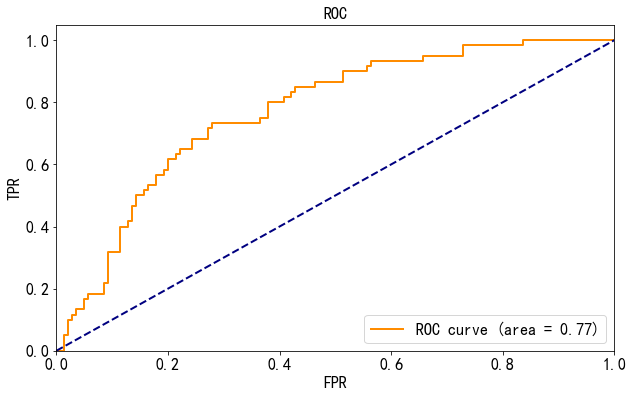

In [20]:
# 计算 FPR 与 TPR
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)

# 计算 AUC 值
roc_auc = auc(fpr, tpr)
ar = 2*roc_auc-1
gini = ar

# 结果绘图
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('FPR',fontsize=16)
plt.ylabel('TPR',fontsize=16)
plt.title('ROC',fontsize=16)
plt.legend(loc="lower right",fontsize=16)

#### <font color=blue>查看测试集 K-S曲线</font>
a. K-S曲线由 正 / 负样本的洛伦兹曲线，以及正 / 负样本的洛伦兹曲线的差值（KS值）组成；  

b. 正样本的洛伦兹曲线 与 ROC 本质上相同，区别在于横坐标表示的信息不同：ROC的横坐标是 FPR 假正率（不逾期样本的误判率），正样本的洛伦兹曲线 则是以预测概率降序排列后的分组数为横轴。  

c. 洛伦兹图，即累计提升图，以模型判断得到的每组累计坏样本占比与随机判断每组累计坏样本占比做比值，进行绘图；   

d. KS值 = max ( TPR - FPR ),本例中为绿线。

0.4547619047619047


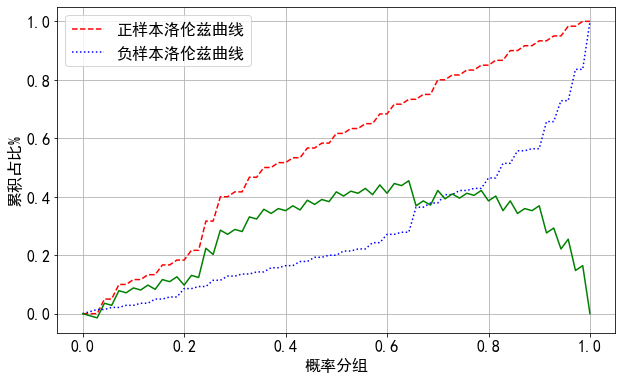

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
print( max(tpr - fpr))

#### <font color=blue>计算测试集的 AR/Gini，KS值</font>
洛伦兹曲线Gini基尼系数 = AR（Accuracy Ratio），将可提升的AUC面积与提升的极限做比值；    

洛伦兹曲线Gini基尼系数 = 2 AUC - 1   

KS值 = TPR - FPR 

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
gini = ar
print('测试集的 AR/基尼系数为:',ar)
print('测试集的KS值为:',ks)

测试集的 AR/基尼系数为: 0.5404761904761906
测试集的KS值为: 0.4547619047619047
